### Data Dictionary

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer
from feature_engine import outlier_removers as outr

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("regression.csv")

In [3]:
df

,Street,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,Age,Period,Cases
0,EAST 209 STREET,122 BRUCKNER BOULEVARD,2340,46.0,0.90,5.0,6.5,1,15000,200.0,1,2.0,2628,2000,6.02,2458,1935,2000,10454,65,85,2
1,MARMION AVENUE,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,2000,6.02,2458,1931,1994,10454,63,89,1
2,MT HOPE PLACE,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,2628,2000,6.02,2458,1931,2000,10454,69,89,1
3,DR M L KING JR BOULEVARD,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,2628,12500,6.02,2458,1931,2001,10454,70,89,1
4,CLAY AVENUE,148 BRUCKNER BOULEVARD,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,2628,6876,6.02,1719,1920,2009,10454,89,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87030,OGDEN AVENUE,3605 KINGSBRIDGE AVENUE,65250,87.0,5.22,2.0,2.0,775,12500,100.0,1,6.0,2628,59750,0.90,5500,1929,1990,10463,61,91,6
87031,MACOMBS ROAD,3610 CORLEAR AVENUE,1620,36.0,0.90,2.0,2.0,880,1800,100.0,1,2.0,2628,1296,0.90,2458,1940,2000,10463,60,80,3
87032,EAST TREMONT AVENUE,3616 CORLEAR AVENUE,1616,44.0,0.65,2.0,2.0,881,2500,100.0,1,1.0,2628,944,0.90,2458,1951,2000,10463,49,69,5
87033,UNDERCLIFF AVENUE,3633 KINGSBRIDGE AVENUE,1880,45.0,0.25,2.0,2.0,882,7500,100.0,2,1.0,2628,2000,0.90,2458,1950,2000,10463,50,70,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87035 entries, 0 to 87034
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Street      87035 non-null  object 
 1   Address     87035 non-null  object 
 2   BldgArea    87035 non-null  int64  
 3   BldgDepth   87035 non-null  float64
 4   BuiltFAR    87035 non-null  float64
 5   CommFAR     87035 non-null  float64
 6   FacilFAR    87035 non-null  float64
 7   Lot         87035 non-null  int64  
 8   LotArea     87035 non-null  int64  
 9   LotDepth    87035 non-null  float64
 10  NumBldgs    87035 non-null  int64  
 11  NumFloors   87035 non-null  float64
 12  OfficeArea  87035 non-null  int64  
 13  ResArea     87035 non-null  int64  
 14  ResidFAR    87035 non-null  float64
 15  RetailArea  87035 non-null  int64  
 16  YearBuilt   87035 non-null  int64  
 17  YearAlter1  87035 non-null  int64  
 18  ZipCode     87035 non-null  int64  
 19  Age         87035 non-nul

In [5]:
df.describe(include='all')

,Street,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,Age,Period,Cases
count,87035,87035,8.703500e+04,87035.000000,87035.000000,87035.00000,87035.000000,87035.000000,8.703500e+04,87035.000000,87035.000000,87035.000000,8.703500e+04,8.703500e+04,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000
unique,1061,84515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GRAND CONCOURSE,SHORE DRIVE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4859,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.219029e+03,51.794101,1.183555,1.99657,2.918405,81.020796,9.453427e+03,105.818433,1.252979,2.417926,3.071636e+03,5.983456e+03,1.762191,2650.277107,1942.811398,1999.799782,10464.108175,56.988384,77.188602,1.032389
std,NaN,NaN,6.589725e+04,28.225133,1.795648,0.30937,1.572439,397.712592,2.921665e+05,73.102999,1.920538,1.346020,1.205355e+04,5.722332e+04,1.262625,4855.982830,28.892664,3.972249,7.310235,28.933901,28.892664,0.564331
min,NaN,NaN,1.000000e+00,2.000000,0.010000,0.50000,1.000000,1.000000,1.000000e+00,0.080000,1.000000,0.500000,5.000000e+01,1.000000e+02,0.500000,100.000000,1780.000000,1905.000000,10451.000000,-91.000000,3.000000,1.000000
25%,NaN,NaN,1.764000e+03,36.000000,0.650000,2.00000,2.000000,19.000000,2.185000e+03,95.000000,1.000000,2.000000,2.628000e+03,1.480000e+03,0.900000,2458.000000,1925.000000,2000.000000,10460.000000,40.000000,60.000000,1.000000
50%,NaN,NaN,2.340000e+03,46.000000,0.900000,2.00000,2.000000,40.000000,2.500000e+03,100.000000,1.000000,2.000000,2.628000e+03,2.000000e+03,1.250000,2458.000000,1935.000000,2000.000000,10465.000000,65.000000,85.000000,1.000000
75%,NaN,NaN,3.280000e+03,56.000000,1.260000,2.00000,4.800000,69.000000,4.053000e+03,101.900000,1.000000,3.000000,2.628000e+03,2.600000e+03,2.430000,2458.000000,1960.000000,2000.000000,10469.000000,75.000000,95.000000,1.000000


In [6]:
df.shape

(87035, 22)

In [7]:
df.columns

Index(['Street', 'Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'ZipCode', 'Age', 'Period', 'Cases'],
      dtype='object')

### Drop unwanted features

In [8]:
df.columns

Index(['Street', 'Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'ZipCode', 'Age', 'Period', 'Cases'],
      dtype='object')

In [9]:
df.drop(['Street', 'Address','Lot','YearBuilt','YearAlter1', 'ZipCode'],axis=1,inplace=True)

In [10]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,Cases
0,2340,46.0,0.90,5.0,6.5,15000,200.0,1,2.0,2628,2000,6.02,2458,65,85,2
1,752,16.0,0.05,5.0,6.5,13770,100.0,2,1.0,272,2000,6.02,2458,63,89,1
2,39375,200.0,1.13,5.0,6.5,35000,200.0,1,2.0,2628,2000,6.02,2458,69,89,1
3,12500,85.0,5.00,5.0,6.5,2500,100.0,1,5.0,2628,12500,6.02,2458,70,89,1
4,8595,70.0,4.58,5.0,6.5,1875,75.0,1,5.0,2628,6876,6.02,1719,89,100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87030,65250,87.0,5.22,2.0,2.0,12500,100.0,1,6.0,2628,59750,0.90,5500,61,91,6
87031,1620,36.0,0.90,2.0,2.0,1800,100.0,1,2.0,2628,1296,0.90,2458,60,80,3
87032,1616,44.0,0.65,2.0,2.0,2500,100.0,1,1.0,2628,944,0.90,2458,49,69,5
87033,1880,45.0,0.25,2.0,2.0,7500,100.0,2,1.0,2628,2000,0.90,2458,50,70,7


### Data Visualization

In [11]:
df['Cases'].value_counts()

1     86335
2       246
3       117
4        80
5        62
6        50
8        28
7        27
9        22
10        8
11        8
13        8
12        6
14        5
15        5
16        5
19        5
18        4
20        2
21        2
35        2
37        1
22        1
23        1
27        1
29        1
32        1
34        1
43        1
Name: Cases, dtype: int64

### Univariate Data Exploration

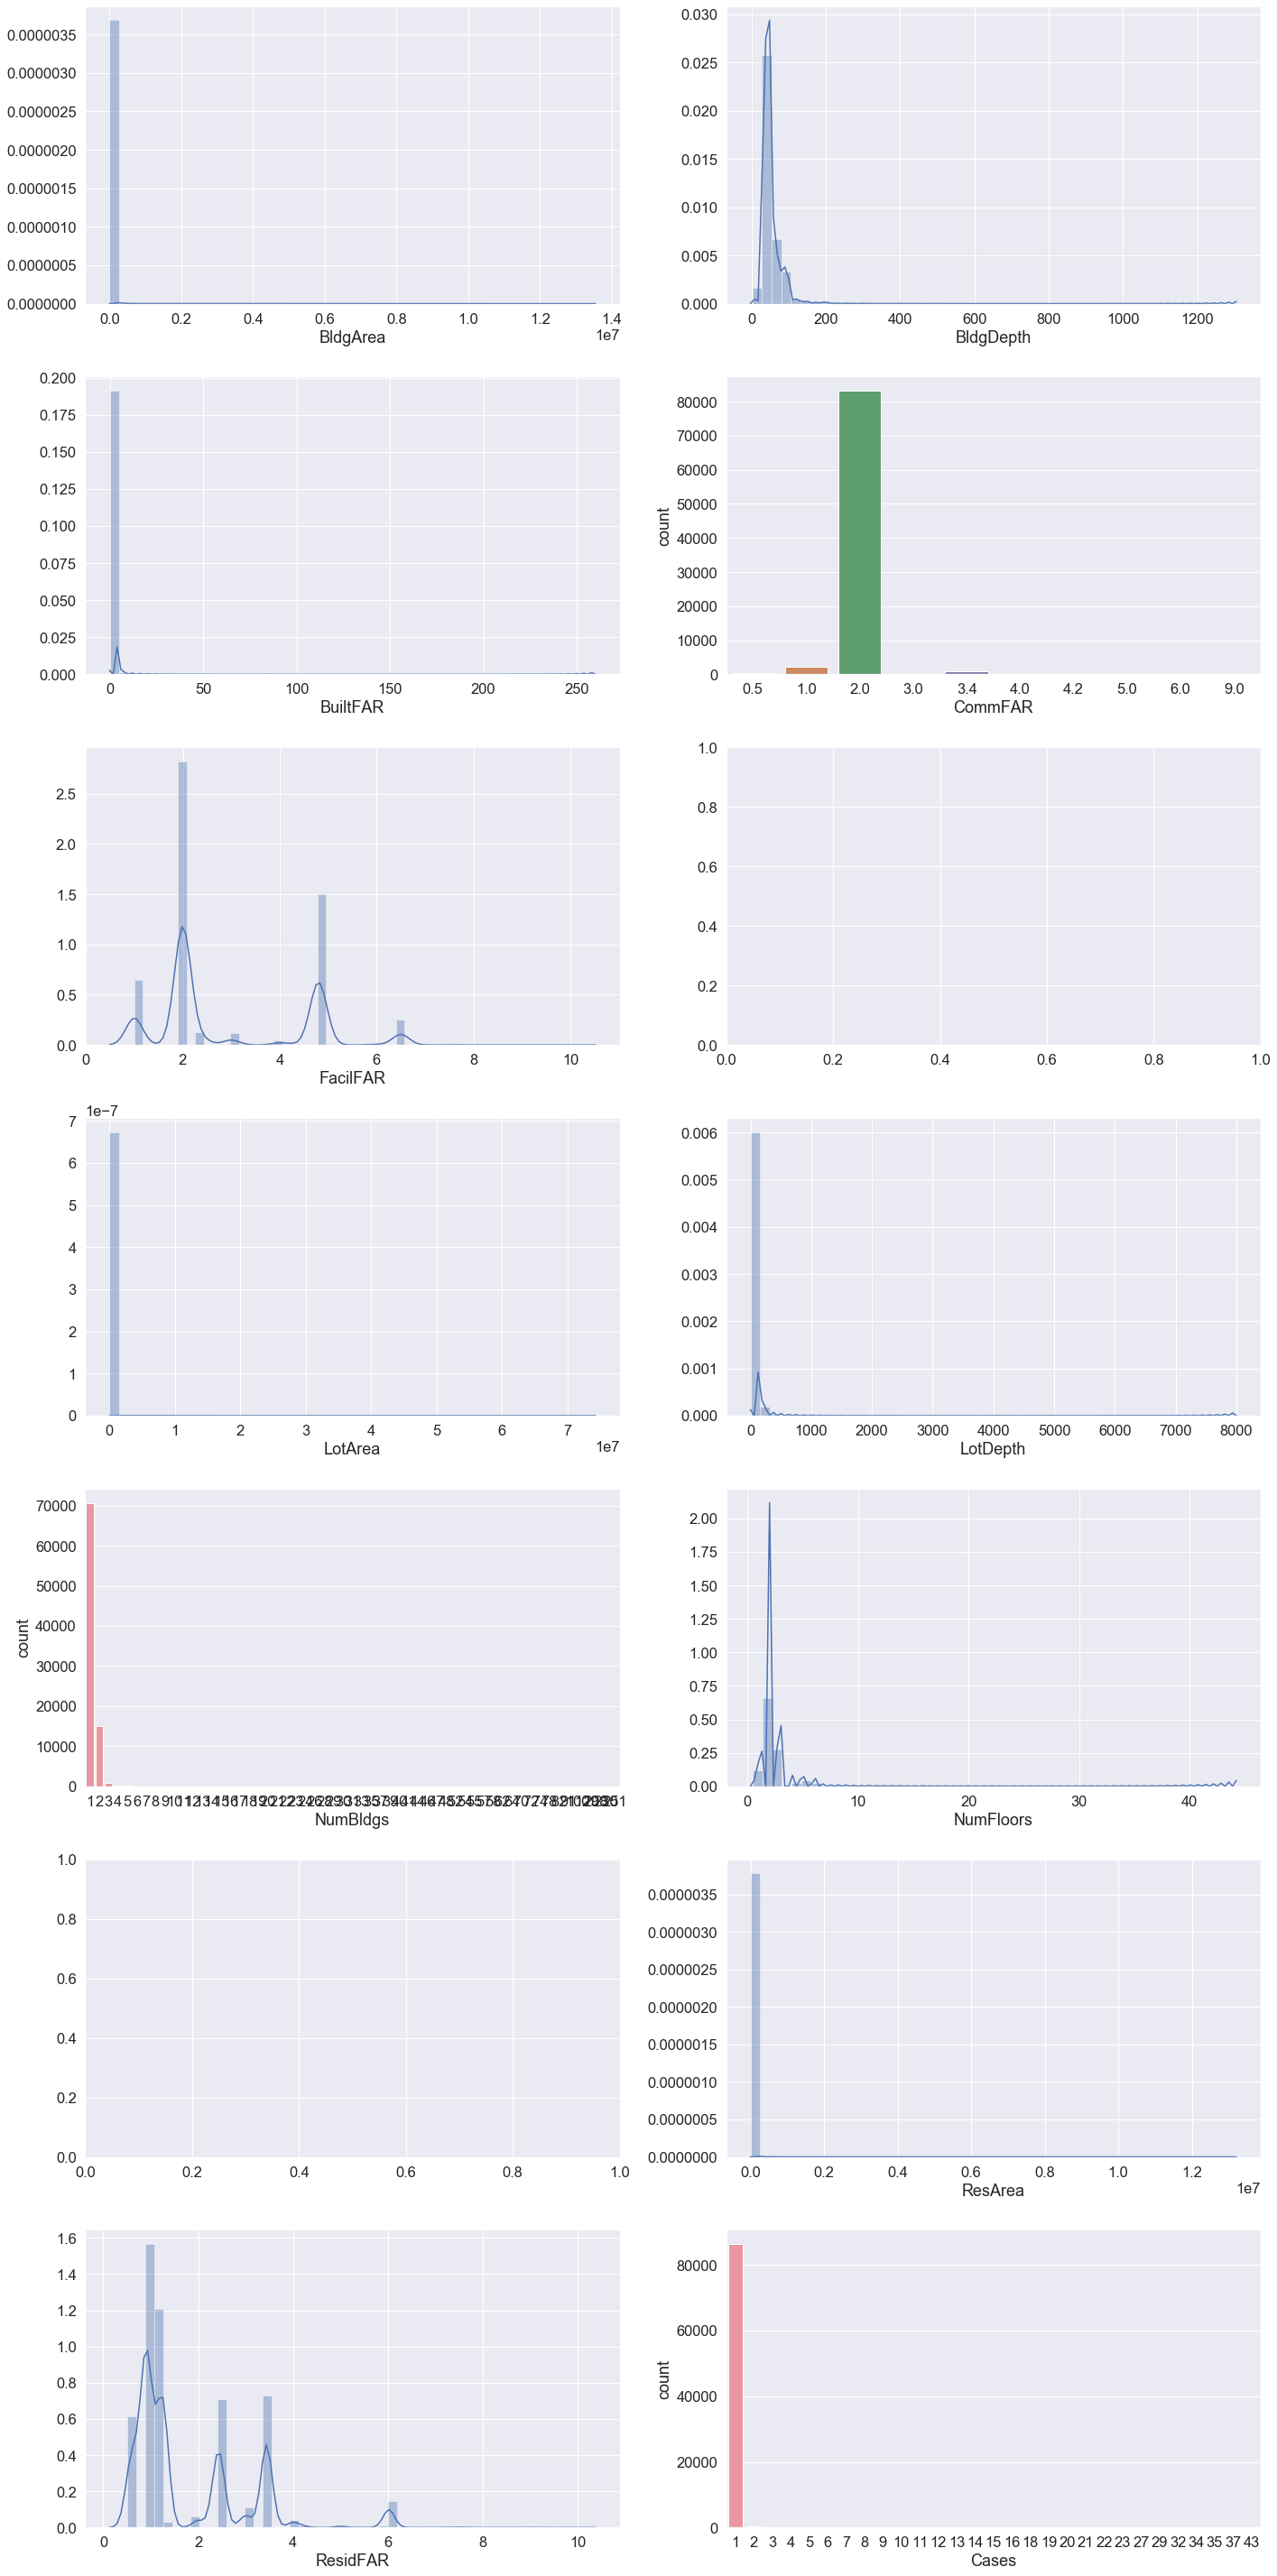

In [12]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.BldgArea)
plt.subplot(7,2,2)
sns.distplot(df.BldgDepth)
plt.subplot(7,2,3)
sns.distplot(df.BuiltFAR)
plt.subplot(7,2,4)
sns.countplot(df.CommFAR)
plt.subplot(7,2,5)
sns.distplot(df.FacilFAR)
plt.subplot(7,2,6)
# sns.distplot(df.)
plt.subplot(7,2,7)
sns.distplot(df.LotArea)
plt.subplot(7,2,8)
sns.distplot(df.LotDepth)
plt.subplot(7,2,9)
sns.countplot(df.NumBldgs)
plt.subplot(7,2,10)
sns.distplot(df.NumFloors)
plt.subplot(7,2,11)
# sns.countplot(df.OfficeArea)
plt.subplot(7,2,12)
sns.distplot(df.ResArea)
plt.subplot(7,2,13)
sns.distplot(df.ResidFAR)
plt.subplot(7,2,14)
sns.countplot(df.Cases)

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

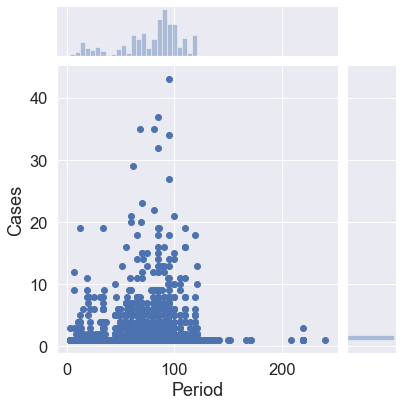

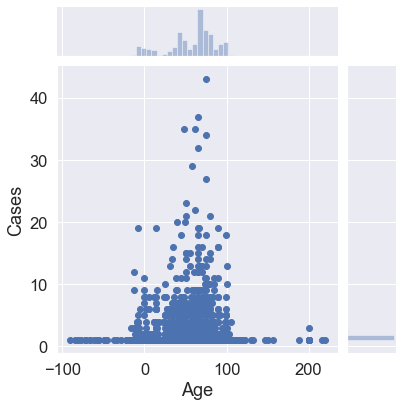

In [13]:
sns.jointplot(x='Period', y='Cases',data=df, kind='scatter')

sns.jointplot(x='Age', y='Cases',data=df, kind='scatter')


plt.show()

In [14]:
df.corr()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,Cases
BldgArea,1.000000,0.267703,0.281034,0.018718,0.098052,0.176289,0.227615,0.543065,0.373210,0.229092,0.892806,0.095194,0.164840,-0.027741,-0.023979,0.003551
BldgDepth,0.267703,1.000000,0.251174,0.034327,0.328236,0.041765,0.265769,0.036047,0.302292,0.203624,0.148144,0.303165,0.193074,0.001069,0.018173,-0.005387
BuiltFAR,0.281034,0.251174,1.000000,0.045519,0.257552,-0.000835,-0.003397,0.074733,0.432389,0.039064,0.272275,0.269767,0.336011,-0.004124,0.005733,-0.005979
CommFAR,0.018718,0.034327,0.045519,1.000000,0.205919,-0.003392,-0.018758,-0.004621,0.054822,0.024456,0.005412,0.208359,0.071088,0.025212,0.026270,-0.001239
FacilFAR,0.098052,0.328236,0.257552,0.205919,1.000000,0.000759,0.014626,-0.028879,0.321186,0.038876,0.083968,0.884599,0.051585,0.043376,0.054334,-0.020744
LotArea,0.176289,0.041765,-0.000835,-0.003392,0.000759,1.000000,0.330884,0.331217,0.030407,0.080399,0.076704,-0.000352,0.015606,-0.002898,-0.001782,0.000619
LotDepth,0.227615,0.265769,-0.003397,-0.018758,0.014626,0.330884,1.000000,0.198662,0.095691,0.162090,0.130718,0.007285,0.094531,-0.019682,-0.016058,0.010869
NumBldgs,0.543065,0.036047,0.074733,-0.004621,-0.028879,0.331217,0.198662,1.000000,0.050841,0.068560,0.457720,-0.034664,0.049253,0.033653,0.032763,-0.002525
NumFloors,0.373210,0.302292,0.432389,0.054822,0.321186,0.030407,0.095691,0.050841,1.000000,0.071243,0.376784,0.354326,0.014979,-0.079940,-0.068003,0.007796
OfficeArea,0.229092,0.203624,0.039064,0.024456,0.038876,0.080399,0.162090,0.068560,0.071243,1.000000,0.020554,0.034503,0.043939,-0.015160,-0.013115,-0.001550


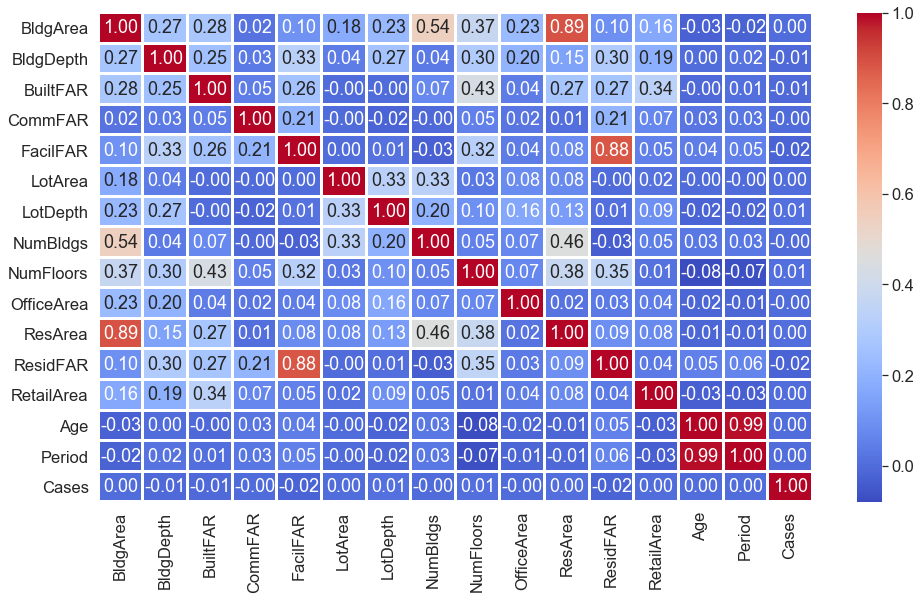

In [15]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

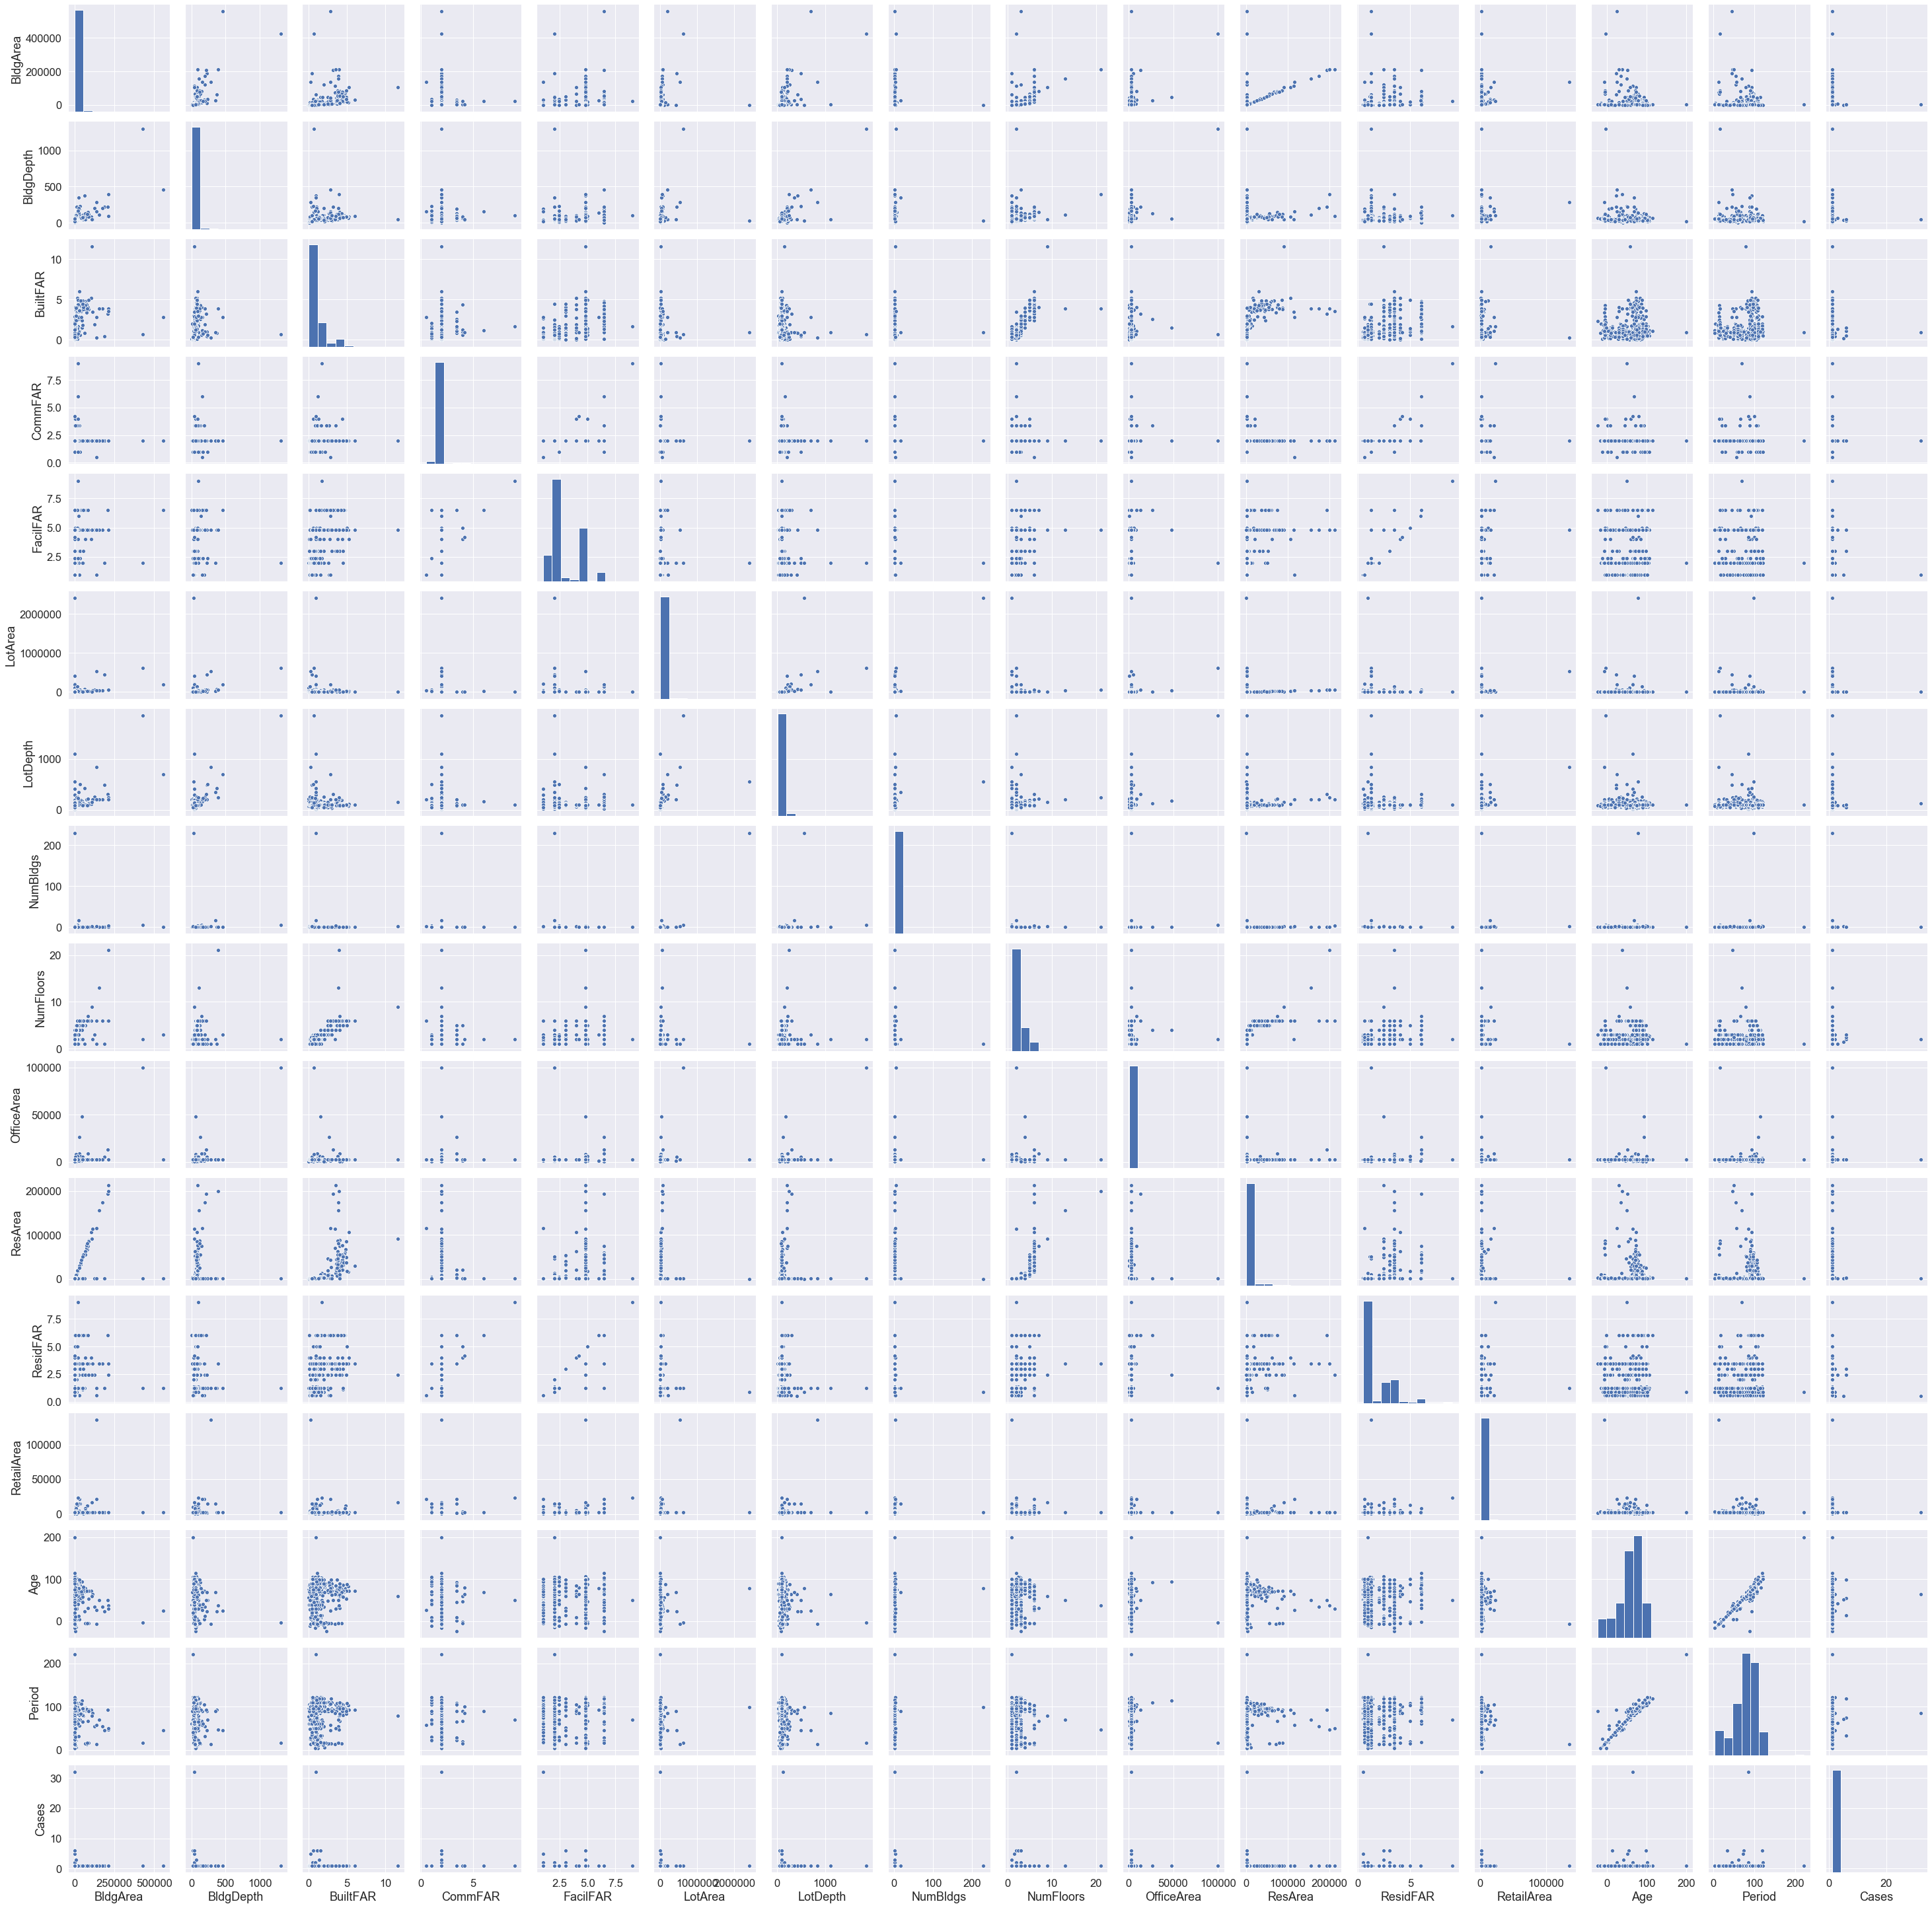

In [16]:
sns.pairplot(df.sample(1000))
plt.show()

### Data Preprocessing

### Treat Missing Values

In [17]:
df.isnull().sum()

BldgArea      0
BldgDepth     0
BuiltFAR      0
CommFAR       0
FacilFAR      0
LotArea       0
LotDepth      0
NumBldgs      0
NumFloors     0
OfficeArea    0
ResArea       0
ResidFAR      0
RetailArea    0
Age           0
Period        0
Cases         0
dtype: int64

### Treat Outliers

In [18]:
df.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'Cases'],
      dtype='object')

In [19]:
df.describe()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,Cases
count,8.703500e+04,87035.000000,87035.000000,87035.00000,87035.000000,8.703500e+04,87035.000000,87035.000000,87035.000000,8.703500e+04,8.703500e+04,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000
mean,8.219029e+03,51.794101,1.183555,1.99657,2.918405,9.453427e+03,105.818433,1.252979,2.417926,3.071636e+03,5.983456e+03,1.762191,2650.277107,56.988384,77.188602,1.032389
std,6.589725e+04,28.225133,1.795648,0.30937,1.572439,2.921665e+05,73.102999,1.920538,1.346020,1.205355e+04,5.722332e+04,1.262625,4855.982830,28.933901,28.892664,0.564331
min,1.000000e+00,2.000000,0.010000,0.50000,1.000000,1.000000e+00,0.080000,1.000000,0.500000,5.000000e+01,1.000000e+02,0.500000,100.000000,-91.000000,3.000000,1.000000
25%,1.764000e+03,36.000000,0.650000,2.00000,2.000000,2.185000e+03,95.000000,1.000000,2.000000,2.628000e+03,1.480000e+03,0.900000,2458.000000,40.000000,60.000000,1.000000
50%,2.340000e+03,46.000000,0.900000,2.00000,2.000000,2.500000e+03,100.000000,1.000000,2.000000,2.628000e+03,2.000000e+03,1.250000,2458.000000,65.000000,85.000000,1.000000
75%,3.280000e+03,56.000000,1.260000,2.00000,4.800000,4.053000e+03,101.900000,1.000000,3.000000,2.628000e+03,2.600000e+03,2.430000,2458.000000,75.000000,95.000000,1.000000
max,1.354011e+07,1300.000000,259.800000,9.00000,10.000000,7.425000e+07,8000.000000,251.000000,44.000000,1.311800e+06,1.321140e+07,10.000000,598908.000000,220.000000,240.000000,43.000000


In [20]:
df['BldgArea'].quantile(0.75)

3280.0

In [21]:
df['BldgDepth'].quantile(0.75)

56.0

In [22]:
df['BuiltFAR'].quantile(0.75)

1.26

In [23]:
df['CommFAR'].quantile(0.75)

2.0

In [24]:
df['FacilFAR'].quantile(0.75)

4.8

In [25]:
df['LotArea'].quantile(0.75)

4053.0

In [26]:
df['LotDepth'].quantile(0.75)

101.9

In [27]:
df['NumBldgs'].quantile(0.75)

1.0

In [28]:
df['NumFloors'].quantile(0.75)

3.0

In [29]:
df['OfficeArea'].quantile(0.75)

2628.0

In [30]:
df['ResArea'].quantile(0.75)

2600.0

In [31]:
df['ResidFAR'].quantile(0.75)

2.43

In [32]:
df['RetailArea'].quantile(0.75)

2458.0

In [33]:
df['Age'].quantile(0.75)

75.0

In [34]:
df['Period'].quantile(0.75)

95.0

In [35]:
df.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'Cases'],
      dtype='object')

In [36]:
capper = outr.ArbitraryOutlierCapper(max_capping_dict={'BldgArea':3280.0,'BldgDepth':56.0,'BuiltFAR':1.26,
                                                       'CommFAR':2.0,'FacilFAR':4.8,'LotArea':4053.0,
                                                       'LotDepth':101.9,'NumBldgs':1.0,'NumFloors':3.0,
                                                       'OfficeArea':2628.0,'ResArea':2600.0,'ResidFAR':2.43,
                                                       'RetailArea':2458.0,'Age':75.0,'Period':95.0},
                                                        min_capping_dict=None)

In [37]:
capper.right_tail_caps_

{'BldgArea': 3280.0,
 'BldgDepth': 56.0,
 'BuiltFAR': 1.26,
 'CommFAR': 2.0,
 'FacilFAR': 4.8,
 'LotArea': 4053.0,
 'LotDepth': 101.9,
 'NumBldgs': 1.0,
 'NumFloors': 3.0,
 'OfficeArea': 2628.0,
 'ResArea': 2600.0,
 'ResidFAR': 2.43,
 'RetailArea': 2458.0,
 'Age': 75.0,
 'Period': 95.0}

In [38]:
capper.left_tail_caps_

{}

In [39]:
df2 = capper.fit_transform(df)

In [40]:
df2.describe()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,Cases
count,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.0,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000,87035.000000
mean,2358.019498,44.771584,0.887115,1.968880,2.835310,2828.889332,94.771601,1.0,2.184488,2608.301178,1948.949400,1.473576,2419.427265,53.754938,73.992084,1.032389
std,752.346190,9.780036,0.315327,0.181765,1.417305,891.238555,13.390113,0.0,0.595463,181.496428,543.014087,0.718241,230.158410,25.336564,25.382155,0.564331
min,1.000000,2.000000,0.010000,0.500000,1.000000,1.000000,0.080000,1.0,0.500000,50.000000,100.000000,0.500000,100.000000,-91.000000,3.000000,1.000000
25%,1764.000000,36.000000,0.650000,2.000000,2.000000,2185.000000,95.000000,1.0,2.000000,2628.000000,1480.000000,0.900000,2458.000000,40.000000,60.000000,1.000000
50%,2340.000000,46.000000,0.900000,2.000000,2.000000,2500.000000,100.000000,1.0,2.000000,2628.000000,2000.000000,1.250000,2458.000000,65.000000,85.000000,1.000000
75%,3280.000000,56.000000,1.260000,2.000000,4.800000,4052.500000,101.900000,1.0,3.000000,2628.000000,2600.000000,2.430000,2458.000000,75.000000,95.000000,1.000000
max,3280.000000,56.000000,1.260000,2.000000,4.800000,4053.000000,101.900000,1.0,3.000000,2628.000000,2600.000000,2.430000,2458.000000,75.000000,95.000000,43.000000


In [41]:
df2

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,Cases
0,2340.0,46.0,0.90,2.0,4.8,4053.0,101.9,1.0,2.0,2628.0,2000.0,2.43,2458.0,65.0,85.0,2
1,752.0,16.0,0.05,2.0,4.8,4053.0,100.0,1.0,1.0,272.0,2000.0,2.43,2458.0,63.0,89.0,1
2,3280.0,56.0,1.13,2.0,4.8,4053.0,101.9,1.0,2.0,2628.0,2000.0,2.43,2458.0,69.0,89.0,1
3,3280.0,56.0,1.26,2.0,4.8,2500.0,100.0,1.0,3.0,2628.0,2600.0,2.43,2458.0,70.0,89.0,1
4,3280.0,56.0,1.26,2.0,4.8,1875.0,75.0,1.0,3.0,2628.0,2600.0,2.43,1719.0,75.0,95.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87030,3280.0,56.0,1.26,2.0,2.0,4053.0,100.0,1.0,3.0,2628.0,2600.0,0.90,2458.0,61.0,91.0,6
87031,1620.0,36.0,0.90,2.0,2.0,1800.0,100.0,1.0,2.0,2628.0,1296.0,0.90,2458.0,60.0,80.0,3
87032,1616.0,44.0,0.65,2.0,2.0,2500.0,100.0,1.0,1.0,2628.0,944.0,0.90,2458.0,49.0,69.0,5
87033,1880.0,45.0,0.25,2.0,2.0,4053.0,100.0,1.0,1.0,2628.0,2000.0,0.90,2458.0,50.0,70.0,7


### Create and save processed dataset

In [42]:
#df2.to_csv("regtrain.csv",index=False)

### Train Test Split

In [43]:
X = df2.iloc[:,0:15]
y = df2.iloc[:,15]

In [44]:
X.values, y.values

(array([[2.340e+03, 4.600e+01, 9.000e-01, ..., 2.458e+03, 6.500e+01,
         8.500e+01],
        [7.520e+02, 1.600e+01, 5.000e-02, ..., 2.458e+03, 6.300e+01,
         8.900e+01],
        [3.280e+03, 5.600e+01, 1.130e+00, ..., 2.458e+03, 6.900e+01,
         8.900e+01],
        ...,
        [1.616e+03, 4.400e+01, 6.500e-01, ..., 2.458e+03, 4.900e+01,
         6.900e+01],
        [1.880e+03, 4.500e+01, 2.500e-01, ..., 2.458e+03, 5.000e+01,
         7.000e+01],
        [1.782e+03, 3.600e+01, 9.900e-01, ..., 2.458e+03, 6.000e+01,
         8.000e+01]]),
 array([2, 1, 1, ..., 5, 7, 1], dtype=int64))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69628, 15), (17407, 15), (69628,), (17407,))

### Feature Scaling

In [47]:
X_train

array([[2.599e+03, 4.500e+01, 6.400e-01, ..., 2.458e+03, 5.000e+01,
        7.000e+01],
       [1.559e+03, 2.825e+01, 3.300e-01, ..., 2.458e+03, 5.500e+01,
        7.500e+01],
       [2.180e+03, 4.500e+01, 8.700e-01, ..., 2.458e+03, 4.500e+01,
        6.500e+01],
       ...,
       [2.420e+03, 4.700e+01, 1.100e+00, ..., 2.458e+03, 4.500e+01,
        6.500e+01],
       [2.320e+03, 5.600e+01, 9.300e-01, ..., 2.458e+03, 7.500e+01,
        9.500e+01],
       [1.260e+03, 3.500e+01, 5.100e-01, ..., 2.458e+03, 6.000e+01,
        8.000e+01]])

In [48]:
scaler = StandardScaler()

In [49]:
X_train_scaled = scaler.fit_transform(X_train)

In [50]:
X_test_scaled = scaler.transform(X_test)

In [51]:
X_train_scaled

array([[ 0.31597246,  0.0202611 , -0.78604797, ...,  0.16768412,
        -0.14633201, -0.15540429],
       [-1.06432883, -1.69185909, -1.76839197, ...,  0.16768412,
         0.05084574,  0.04137912],
       [-0.24012969,  0.0202611 , -0.05721209, ...,  0.16768412,
        -0.34350975, -0.3521877 ],
       ...,
       [ 0.07840138,  0.22469336,  0.67162379, ...,  0.16768412,
        -0.34350975, -0.3521877 ],
       [-0.0543199 ,  1.14463854,  0.13291901, ...,  0.16768412,
         0.83955672,  0.82851275],
       [-1.46116545, -1.00190021, -1.19799868, ...,  0.16768412,
         0.24802348,  0.23816253]])

In [52]:
X_test_scaled

array([[ 1.21980437,  1.14463854,  1.17864005, ...,  0.16768412,
         0.83955672,  0.82851275],
       [-0.08086416, -1.92184538,  0.25967307, ...,  0.16768412,
         0.83955672,  0.82851275],
       [ 1.21980437,  1.14463854,  1.17864005, ...,  0.16768412,
        -1.60544733, -1.61160151],
       ...,
       [-0.02777565,  0.12247723,  0.03785346, ...,  0.16768412,
         0.44520123,  0.43494593],
       [-0.26667395,  0.94020628, -0.62760538, ...,  0.16768412,
         0.83955672,  0.82851275],
       [-0.02777565,  0.12247723,  0.03785346, ...,  0.16768412,
         0.44520123,  0.43494593]])

### Model Training

### Using XGBoost (Scikit-Learn)

In [53]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror')

In [54]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:0.765568
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.735236
[2]	validation_0-rmse:0.709612
[3]	validation_0-rmse:0.688299
[4]	validation_0-rmse:0.670564
[5]	validation_0-rmse:0.655794
[6]	validation_0-rmse:0.643659
[7]	validation_0-rmse:0.633666
[8]	validation_0-rmse:0.625345
[9]	validation_0-rmse:0.618488
[10]	validation_0-rmse:0.61293
[11]	validation_0-rmse:0.608399
[12]	validation_0-rmse:0.60477
[13]	validation_0-rmse:0.601844
[14]	validation_0-rmse:0.599344
[15]	validation_0-rmse:0.597252
[16]	validation_0-rmse:0.595692
[17]	validation_0-rmse:0.594333
[18]	validation_0-rmse:0.593234
[19]	validation_0-rmse:0.592421
[20]	validation_0-rmse:0.591696
[21]	validation_0-rmse:0.591084
[22]	validation_0-rmse:0.590616
[23]	validation_0-rmse:0.590294
[24]	validation_0-rmse:0.589958
[25]	validation_0-rmse:0.589689
[26]	validation_0-rmse:0.589498
[27]	validation_0-rmse:0.589341
[28]	validation_0-rmse:0.589207
[29]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [55]:
y_pred = xgbmodel.predict(X_test_scaled)

In [56]:
y_pred

array([1.0138187, 1.17226  , 1.0411198, ..., 1.0092201, 1.0372591,
       1.0270967], dtype=float32)

### Model Evaluation

In [57]:
mse = mean_squared_error(y_test,y_pred)
mse

0.34330857892451344

In [58]:
rmse = np.sqrt(mse)
rmse

0.5859254038907286

In [59]:
r2score = r2_score(y_test,y_pred)
r2score

0.04447317991996269

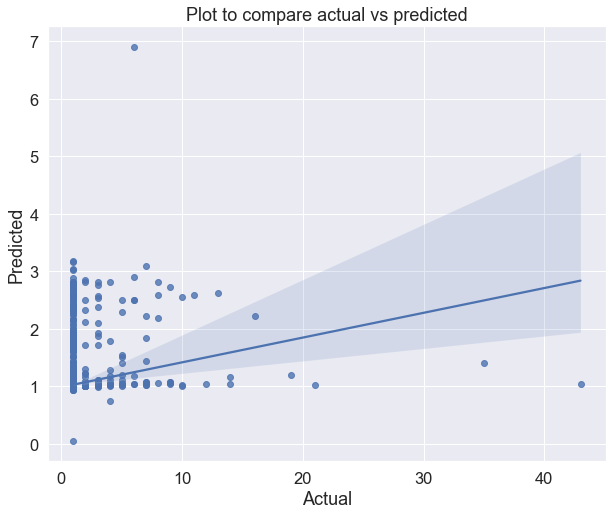

In [60]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [61]:
X.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period'],
      dtype='object')

In [62]:
xgbmodel.get_booster().feature_names = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period']

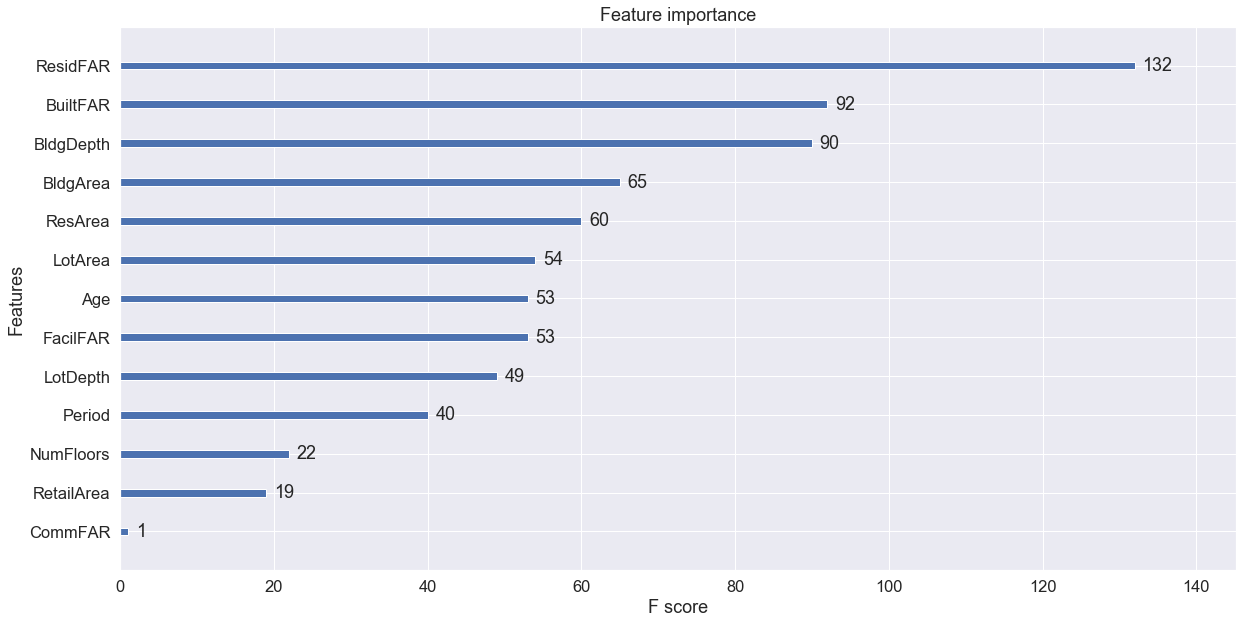

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

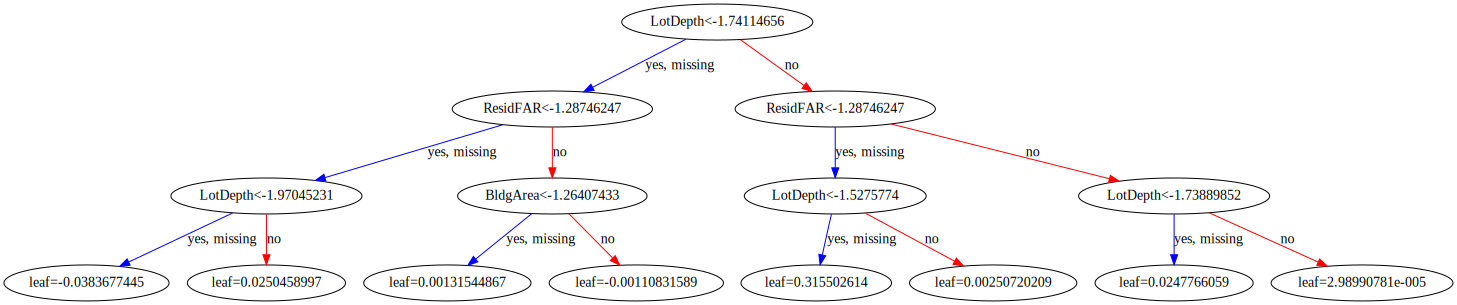

In [64]:
xgb.to_graphviz(xgbmodel,num_trees=100)

### Cross-Validation

In [65]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.9s finished


In [66]:
cv.mean()

0.03971731489803112

### Feature Selection

In [67]:
df2.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'Cases'],
      dtype='object')

In [68]:
df3 = df2[['ResidFAR','BuiltFAR','BldgDepth','BldgArea','ResArea','LotArea','Age', 'Cases']]

In [69]:
df3

,ResidFAR,BuiltFAR,BldgDepth,BldgArea,ResArea,LotArea,Age,Cases
0,2.43,0.90,46.0,2340.0,2000.0,4053.0,65.0,2
1,2.43,0.05,16.0,752.0,2000.0,4053.0,63.0,1
2,2.43,1.13,56.0,3280.0,2000.0,4053.0,69.0,1
3,2.43,1.26,56.0,3280.0,2600.0,2500.0,70.0,1
4,2.43,1.26,56.0,3280.0,2600.0,1875.0,75.0,1
...,...,...,...,...,...,...,...,...
87030,0.90,1.26,56.0,3280.0,2600.0,4053.0,61.0,6
87031,0.90,0.90,36.0,1620.0,1296.0,1800.0,60.0,3
87032,0.90,0.65,44.0,1616.0,944.0,2500.0,49.0,5
87033,0.90,0.25,45.0,1880.0,2000.0,4053.0,50.0,7


In [70]:
X = df3.iloc[:,0:7]
y = df3.iloc[:,7]

In [71]:
X.values, y.values

(array([[2.430e+00, 9.000e-01, 4.600e+01, ..., 2.000e+03, 4.053e+03,
         6.500e+01],
        [2.430e+00, 5.000e-02, 1.600e+01, ..., 2.000e+03, 4.053e+03,
         6.300e+01],
        [2.430e+00, 1.130e+00, 5.600e+01, ..., 2.000e+03, 4.053e+03,
         6.900e+01],
        ...,
        [9.000e-01, 6.500e-01, 4.400e+01, ..., 9.440e+02, 2.500e+03,
         4.900e+01],
        [9.000e-01, 2.500e-01, 4.500e+01, ..., 2.000e+03, 4.053e+03,
         5.000e+01],
        [9.000e-01, 9.900e-01, 3.600e+01, ..., 1.296e+03, 1.800e+03,
         6.000e+01]]),
 array([2, 1, 1, ..., 5, 7, 1], dtype=int64))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [73]:
scaler = StandardScaler()

In [74]:
X_train_scaled = scaler.fit_transform(X_train)

In [75]:
X_test_scaled = scaler.transform(X_test)

In [76]:
xgbmodel2 = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror')

In [77]:
xgbmodel2.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:0.765568
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.735236
[2]	validation_0-rmse:0.709612
[3]	validation_0-rmse:0.688299
[4]	validation_0-rmse:0.670518
[5]	validation_0-rmse:0.655832
[6]	validation_0-rmse:0.64366
[7]	validation_0-rmse:0.633439
[8]	validation_0-rmse:0.625269
[9]	validation_0-rmse:0.618381
[10]	validation_0-rmse:0.612861
[11]	validation_0-rmse:0.608392
[12]	validation_0-rmse:0.604716
[13]	validation_0-rmse:0.601733
[14]	validation_0-rmse:0.599313
[15]	validation_0-rmse:0.597289
[16]	validation_0-rmse:0.595623
[17]	validation_0-rmse:0.594282
[18]	validation_0-rmse:0.593235
[19]	validation_0-rmse:0.592335
[20]	validation_0-rmse:0.591687
[21]	validation_0-rmse:0.591124
[22]	validation_0-rmse:0.590654
[23]	validation_0-rmse:0.590261
[24]	validation_0-rmse:0.589929
[25]	validation_0-rmse:0.589646
[26]	validation_0-rmse:0.589453
[27]	validation_0-rmse:0.589349
[28]	validation_0-rmse:0.589202
[29]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [78]:
y_pred = xgbmodel2.predict(X_test_scaled)

In [79]:
y_pred

array([1.0186852, 1.204561 , 1.053632 , ..., 1.0102482, 1.0146816,
       1.032747 ], dtype=float32)

In [80]:
r2score = r2_score(y_test,y_pred)
r2score

0.0507447406604522

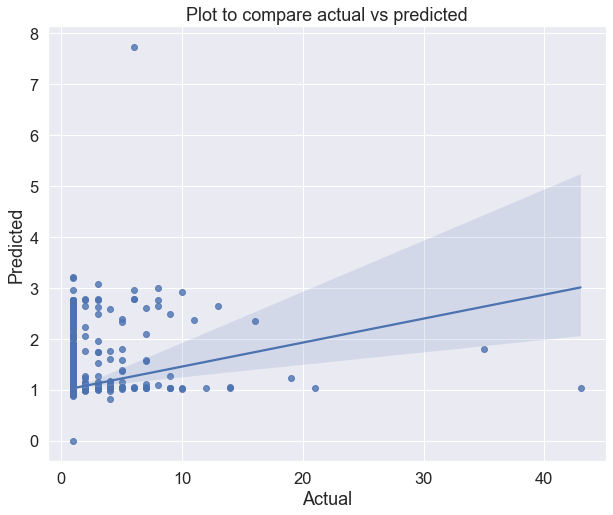

In [81]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Save the Model

In [82]:
filename = 'model311reg.sav'
dump(xgbmodel2,open(filename,'wb'))